# 向量自回归

* [statsmodels](https://www.statsmodels.org/dev/vector_ar.html)
* [VAR - comprehensive guides](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/)
* [Time-series Analysis with VAR and VECM](https://towardsdatascience.com/vector-autoregressions-vector-error-correction-multivariate-model-a69daf6ab618)
* [Multivariate Time-series Modeling](https://www.analyticsvidhya.com/blog/2018/09/multivariate-time-series-guide-forecasting-modeling-python-codes/)

## 1. 简介

向量自回归(vector autoregression): 存在两个以上的时间序列，它们相互影响，将每个变量表示为自身和其它变量滞后项的线性组合，简答来说就是用自身滞后项和相关变量的滞后项作为预测因子，建立多个自回归模型。

AR模型用序列的滞后项预测自身，VAR能够捕捉多个变量间的复杂关系，令预测更加准确。

假设有两个时间序列: $Y_1$和$Y_2$

VAR(1)：

* $Y_{1,t} = \alpha_{1} + \beta_{11,1}Y_{1, t-1} + \beta_{12,1}Y_{2, t-1} + \epsilon_{1, t}$
* $Y_{2,t} = \alpha_{2} + \beta_{21,1}Y_{1, t-1} + \beta_{22,1}Y_{2, t-1} + \epsilon_{2, t}$

VAR(2)：

* $Y_{1,t} = \alpha_{1} + \beta_{11,1}Y_{1, t-1} + \beta_{12,1}Y_{2, t-1} + \beta_{11,2}Y_{1, t-2} + \beta_{12,2}Y_{2, t-2} + \epsilon_{1, t}$
* $Y_{2,t} = \alpha_{2} + \beta_{21,1}Y_{1, t-1} + \beta_{22,1}Y_{2, t-1} + \beta_{21,2}Y_{1, t-2} + \beta_{22,2}Y_{2, t-2} + \epsilon_{2, t}$

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from pandas import DataFrame, Series

%matplotlib inline

## 2. 数据集

我们使用statsmodels提供的宏观经济数据，为简单起见，选择'realgdp','realcons','realinv'3个变量，分别代表美国实际GDP，实际消费和实际投资。

In [3]:
mdata = sm.datasets.macrodata.load_pandas().data
mdata = (mdata.assign(year=lambda x: x["year"].astype(int).astype(str),
                      quarter=lambda x: x["quarter"].astype(int).astype(str),
                      datetime=lambda x: pd.to_datetime(x["year"] + "Q" + x["quarter"]))
              .set_index("datetime")
              .filter(["realgdp", "realcons", "realinv"]))
mdata.tail()

,realgdp,realcons,realinv
datetime,,,
2008-07-01,13324.600,9267.7,1990.693
2008-10-01,13141.920,9195.3,1857.661
2009-01-01,12925.410,9209.2,1558.494
2009-04-01,12901.504,9189.0,1456.678
2009-07-01,12990.341,9256.0,1486.398


## 3. 时间序列分析

时序分析的第一步是可视化，先绘制趋势图。从趋势图可以获得很多信息，例如时间序列是否有趋势，季节性等。

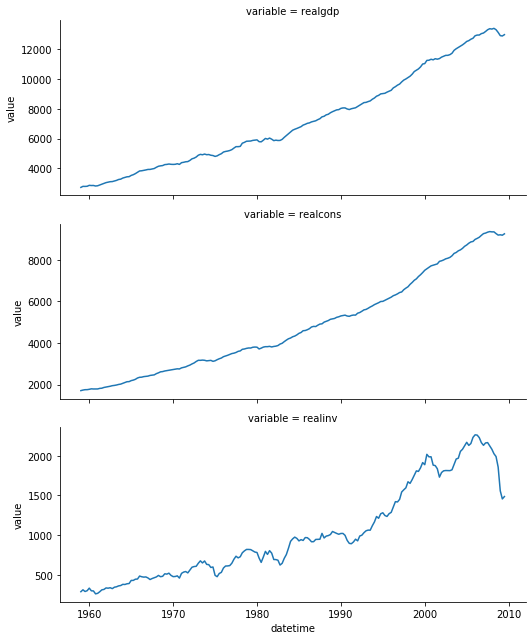

In [4]:
mdata_melt = mdata.reset_index().melt(id_vars=["datetime"])
sns.relplot("datetime", "value", data=mdata_melt, row="variable",
            kind="line", height=3, aspect=2.5, facet_kws={"sharey": False})

从图中可以明显看出，实际GDP，消费和投资都有明显的上升趋势，它们是非平稳的。

先进行一阶差分，然后用ADF检验测试差分序列是否平稳。

In [5]:
def adf_test(ts: Series) -> None:
    """ADF检验，当p值低于选择的显著性水平如0.05，拒绝存在单位根的原假设，
    认为时间序列是平稳的，相反p值大于阈值认为序列非平稳
    """
    ts.dropna(inplace=True)
    res = adfuller(ts, autolag="AIC")
    print(f"ADF statistic: {res[0]:.3f}")
    print(f"p-value: {res[1]:.3f}")
    print(f"used lags: {res[2]}")
    
mdata_diff = mdata.diff().dropna()
# mdata_diff

for col in mdata_diff.columns:
    print(col)
    print("="*30)
    adf_test(mdata_diff[col])
    print("="*30, "\n")

realgdp
ADF statistic: -6.306
p-value: 0.000
used lags: 1

realcons
ADF statistic: -4.204
p-value: 0.001
used lags: 3

realinv
ADF statistic: -5.351
p-value: 0.000
used lags: 2



ADF检验显示，经过一阶差分后的序列是平稳的，我们将使用差分序列进行建模。

## 4. 格兰杰因果检验

#### 什么是格兰杰因果检验（Granger causality test）？

格兰杰因果检验：一个时间序列X是否有助于预测另一个时间序列Y。虽然称为因果检验，但其实是领先-滞后关系检验，检验本身无法揭示经济意义上的因果关系。直觉理解：给定时间序列$X_t$和$Y_t$，拟合两个回归方程，第一个方程用$Y_t$的滞后项预测$Y_t$，第二个方程用$Y_t$和$X_t$的滞后项预测$Y_t$，如果第二个方程的解释能力比第一个强，认为$X_t$是$Y_t$的格兰杰原因。

关于格兰杰检验：

* [Statistics HowTo](https://www.statisticshowto.com/granger-causality/)
* [Wikipedia](https://en.wikipedia.org/wiki/Granger_causality)

#### 为什么进行因果检验？

VAR假设序列相互影响，即可以用该序列和其它变量的滞后项预测自身，简单来说就是存在"因果关系"，如果序列是相互独立的，VAR不适用。

接下来我们调用statsmodels的grangercausalitytests接口，构建辅助函数检验3个宏观经济变量是否存在因果关系？

In [6]:
def granger_test_matrix(df: DataFrame,
                        maxlag: int = 4,
                        test: str = "ssr_ftest") -> DataFrame:
    """对数据框的所有变量进行格兰杰因果检验
    
    Args:
        df(pd.DataFrame): 列变量是要测试的时间序列
        maxlag(int): 最大滞后阶数
        test(str): 检验统计量，可选值为('ssr_ftest', 'ssr_chi2test',
            'lrtest', 'params_ftest')
            
    Returns:
        pd.DataFrame, 记录p值，列是回归方程的自变量(因)，行是回归方程的因变量(果)
    """
    variables = list(df.columns)
    out = pd.DataFrame(
        np.zeros((len(variables), len(variables))),
        index=variables, columns=variables)
    
    for x in out.columns:  # 预测变量
        for y in out.index: # 因变量
            gc_res = grangercausalitytests(df[[y, x]], maxlag, verbose=False)
            pvalue = np.min([gc_res[lag+1][0][test][1] for lag in range(maxlag)])
            out.loc[y, x] = round(pvalue, 4)
    
    return out


granger_test_matrix(mdata_diff)

,realgdp,realcons,realinv
realgdp,1.0000,0.0,0.1292
realcons,0.0171,1.0,0.0022
realinv,0.0000,0.0,1.0000


行变量是果(回归模型的被解释变量)，列变量是因(回归模型的预测变量)，第二行第一个值是0.0171，意味着realgdp是realcons的格兰杰原因，第一行第二列的值是0.0，意味着realcons是realgdp的格兰杰原因。

除第一行第三列的值外，其余p值都低于常见显著性水平0.05，所以我们认为3个变量间相互影响，可以构建VAR模型。

## 5. 建立模型

* 拆分训练集和检验集
* 在训练集拟合模型，选择最优的滞后阶数p
* 拟合最优模型，诊断检验
* 在测试集评估预测能力

### 5.1 拆分训练集和检验集

In [56]:
# 训练集大小
test_size = 10

df_train = mdata.iloc[:-test_size]
df_test = mdata.iloc[-test_size:]

# VAR模型要求时间序列是平稳的，所以先对训练集进行一阶差分
df_train_diff = df_train.diff().dropna()

### 5.2 寻找最优滞后阶数p

网格搜索：

1. 确定p的扫描区间，逐个拟合模型，记录AIC作为拟合优度的衡量指标。
2. 选择AIC最小(即拟合优度)的滞后阶数。

AIC是通用指标而不是唯一的指标，也可以使用BIC衡量拟合优度。

In [57]:
model = VAR(df_train_diff, freq="QS-OCT")

p_rng = list(range(1, 11))
aics = {}

for p in p_rng:
    results = model.fit(p)
    aic = results.aic
    aics.update({p: aic})
    print(f"lag={p} aic={aic}")
    
aics_sort = sorted(aics.items(), key=lambda x: x[1])
print(f"optimal lag = {aics_sort[0][0]}, min aic = {aics_sort[0][1]}")

lag=1 aic=19.710899367309775
lag=2 aic=19.71900654701932
lag=3 aic=19.66057523896647
lag=4 aic=19.721564579820388
lag=5 aic=19.759409383410194
lag=6 aic=19.815978860519156
lag=7 aic=19.84561356998511
lag=8 aic=19.85931337035835
lag=9 aic=19.918771342700236
lag=10 aic=19.968592711625696
optimal lag = 3, min aic = 19.66057523896647


调用model.select_order(max_lag)，也可以获得相同的结果。

In [58]:
results = model.select_order(10)
results.summary()

,AIC,BIC,FPE,HQIC
0,20.27,20.32,6.346e+08,20.29
1,19.80,20.01*,3.969e+08,19.88*
2,19.80,20.17,3.974e+08,19.95
3,19.74*,20.26,3.726e+08*,19.95
4,19.79,20.48,3.948e+08,20.07
5,19.82,20.67,4.062e+08,20.16
6,19.87,20.87,4.272e+08,20.28
7,19.89,21.05,4.358e+08,20.36
8,19.89,21.21,4.358e+08,20.42
9,19.93,21.41,4.580e+08,20.53


### 5.3 拟合最优模型

我们选择3作为最大滞后阶数，拟合VAR(3)，视为最优模型，查看估计系数。

In [59]:
model_fitted = model.fit(3)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 19, Jul, 2020
Time:                     12:00:22
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    20.1751
Nobs:                     189.000    HQIC:                   19.8690
Log likelihood:          -2632.46    FPE:                3.45627e+08
AIC:                      19.6606    Det(Omega_mle):     2.96097e+08
--------------------------------------------------------------------
Results for equation realgdp
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const              18.001958         7.173155            2.510           0.012
L1.realgdp         -0.468027         0.162370           -2.882           0.004
L1.realcons         1.158829         0.198556            5.836    

### 5.4 评估预测能力

In [62]:
# 生成预测值
# 由于输入是一阶差分，预测值也是一阶差分
fc = model_fitted.forecast(model_fitted.endog, steps=len(df_test))
fc_df = pd.DataFrame(fc, columns=df_test.columns, index=df_test.index)
fc_df

,realgdp,realcons,realinv
datetime,,,
2007-04-01,113.631275,66.613453,30.678067
2007-07-01,84.092235,68.412043,4.331948
2007-10-01,89.788769,67.774585,16.682975
2008-01-01,80.004963,54.771050,19.961167
2008-04-01,75.483202,56.758296,12.775608
2008-07-01,71.645767,53.869173,13.544326
2008-10-01,70.071797,49.790893,15.504452
2009-01-01,67.033625,49.857841,12.298525
2009-04-01,65.805266,48.219143,12.989970


In [63]:
# 将预测值的度量单位(一阶差分)转化为原始度量单位
fc_df = fc_df.cumsum(axis=1) + df_train.iloc[-1]
fc_df

,realgdp,realcons,realinv
datetime,,,
2007-04-01,13213.532275,9445.344728,2343.531795
2007-07-01,13183.993235,9417.604278,2289.445226
2007-10-01,13189.689769,9422.663354,2306.855329
2008-01-01,13179.905963,9399.876013,2287.346180
2008-04-01,13175.384202,9397.341499,2277.626106
2008-07-01,13171.546767,9390.614940,2271.668266
2008-10-01,13169.972797,9384.962690,2267.976142
2009-01-01,13166.934625,9381.991466,2261.798991
2009-04-01,13165.706266,9379.124408,2259.623378


In [64]:
# 评估预测精度
def evaluate_accuracy(forecast, actual):
    """计算常用的精度评估指标"""
    # 平均绝对误差 MAE
    mae = np.mean(np.abs(forecast - actual))
    # 平均绝对百分比误差 MAPE
    mape = np.mean(np.abs(forecast - actual) / np.abs(actual))
    # 均方误差 MSE
    mse = np.mean((forecast - actual) ** 2)
    # 均方根误差 RMSE
    rmse = np.sqrt(mse)
    # 实际值和预测值的相关系数
    corr = np.corrcoef(forecast, actual)[0, 1]
    
    return {
        "mae": mae,
        "mape": mape,
        "mse": mse,
        "rmse": rmse,
        "corr": corr
    }


metrics = []
for col in fc_df.columns:
    acc_metrics = evaluate_accuracy(fc_df[col], df_test[col])
    metrics.append(acc_metrics)
    
metrics_df = pd.DataFrame.from_records(metrics, index=fc_df.columns)
metrics_df

,mae,mape,mse,rmse,corr
realgdp,163.575374,0.012410,33458.807346,182.917488,0.454671
realcons,118.691960,0.012828,17001.589877,130.390145,0.609444
realinv,391.082821,0.233162,216609.166403,465.412899,0.748908


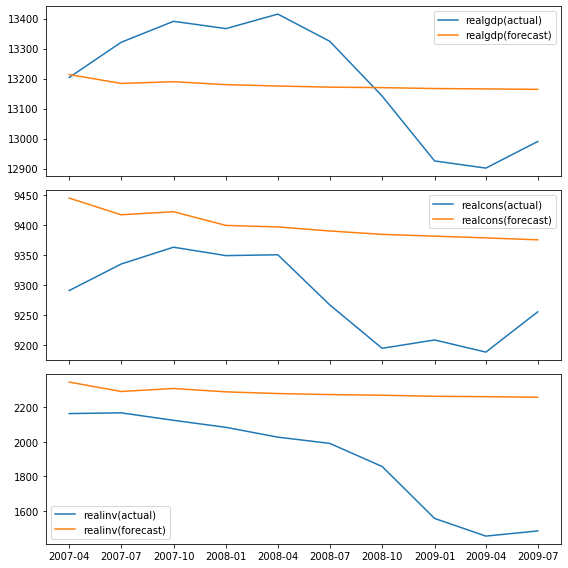

In [65]:
# 可视化，对比实际值和预测值
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 8),
                       sharex=True, sharey=False)

for i, axi in enumerate(ax.flatten()):
    label = df_test.columns[i]
    axi.plot(df_test.iloc[:, i], label=f"{label}(actual)")
    axi.plot(fc_df.iloc[:, i], label=f"{label}(forecast)")
    axi.legend()
    
plt.tight_layout()